# Apple stock price prediction on Google finance

In [1]:
# Imports
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Read data
start = pd.datetime(2011, 1, 1)
end = pd.datetime(2021, 11, 11)

df = web.DataReader('AAPL', data_source='yahoo', start=start, end=end)
# view
df

<ipython-input-2-5c2d15deda1f>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2011, 1, 1)
<ipython-input-2-5c2d15deda1f>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2021, 11, 11)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,11.795000,11.601429,11.630000,11.770357,445138400.0,10.091495
2011-01-04,11.875000,11.719643,11.872857,11.831786,309080800.0,10.144161
2011-01-05,11.940714,11.767857,11.769643,11.928571,255519600.0,10.227143
2011-01-06,11.973214,11.889286,11.954286,11.918929,300428800.0,10.218874
2011-01-07,12.012500,11.853571,11.928214,12.004286,311931200.0,10.292056
...,...,...,...,...,...,...
2021-11-05,152.199997,150.059998,151.889999,151.279999,65414600.0,151.279999
2021-11-08,151.570007,150.160004,151.410004,150.440002,55020900.0,150.440002
2021-11-09,151.429993,150.059998,150.199997,150.809998,56787900.0,150.809998


In [3]:
# get the number of rows and columns in the dataset
df.shape

(2735, 6)

Text(0, 0.5, 'Close Price USD ($)')

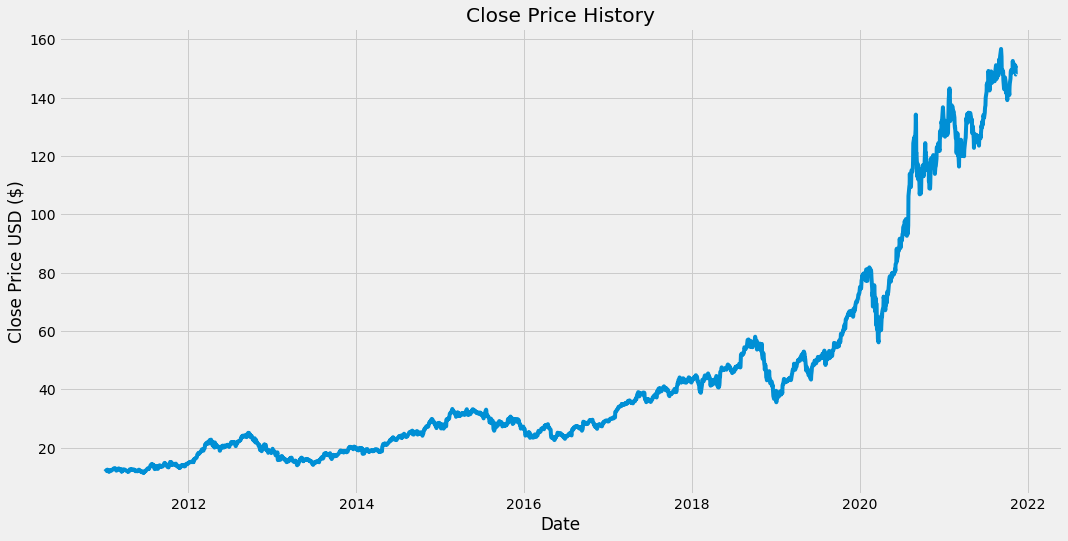

In [4]:
# Visualize the closing price history
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

In [5]:
# Create a new dataframe with only the 'Close column'
close = df.filter(['Close'])
# Convert the dataframe to a numpy array
close_values = close.values

len(close_values)

2735

In [6]:
# Get the number of rows to train the model on // 80% train
training_data_len = math.ceil(len(close_values)*.8)

training_data_len

2188

In [7]:
# Scale the data
# Normalize between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_values)

scaled_data

array([[0.00349951],
       [0.00392191],
       [0.00458742],
       ...,
       [0.95956775],
       [0.93969545],
       [0.94014242]])

In [8]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train datasets
x_train = []
y_train = []

# Range 60 days
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print()
        print(y_train)
        print()

[array([0.00349951, 0.00392191, 0.00458742, 0.00452112, 0.00510805,
       0.00666257, 0.00646366, 0.00714636, 0.00745579, 0.00814341,
       0.00622053, 0.00577603, 0.00426326, 0.00279961, 0.00543468,
       0.00640471, 0.00700638, 0.00684921, 0.00510314, 0.00589391,
       0.00729617, 0.00712181, 0.00690569, 0.00765717, 0.00897839,
       0.00979371, 0.01052063, 0.00963163, 0.01019892, 0.01077112,
       0.01094793, 0.01174116, 0.01055501, 0.00865423, 0.00571954,
       0.00670432, 0.00676817, 0.00806483, 0.00930501, 0.00834725,
       0.00903732, 0.01086444, 0.0109725 , 0.00983301, 0.00993124,
       0.00912328, 0.00769892, 0.0090054 , 0.00939096, 0.0073944 ,
       0.00360756, 0.0047446 , 0.00376964, 0.005889  , 0.00635559,
       0.00586198, 0.00728143, 0.00889489, 0.00862475, 0.00875245])]

[0.008180249059707115]

[array([0.00349951, 0.00392191, 0.00458742, 0.00452112, 0.00510805,
       0.00666257, 0.00646366, 0.00714636, 0.00745579, 0.00814341,
       0.00622053, 0.00577603, 0.

In [9]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2128, 60, 1)

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2128/2128 [==============================] - 35s 15ms/step - loss: 1.7834e-04 2s - loss: - ETA: 1s - loss: 1. - ETA: 0s - 


In [14]:
# Create th testing dataset
# Create a nem array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60:, :]
# Create the datasets x_test and y_test
x_test = []
y_test = close_values[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [15]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

2.687652741315378

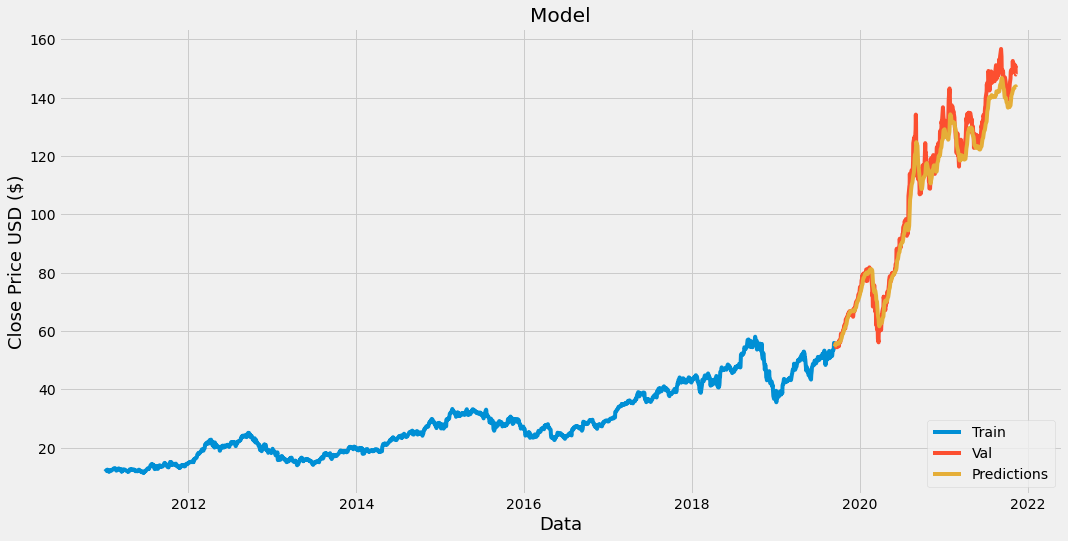

In [19]:
# plot the data 
train = close[:training_data_len].copy()
valid = close[training_data_len:].copy()
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16, 8));
plt.title('Model');
plt.xlabel('Data', fontsize=18);
plt.ylabel('Close Price USD ($)', fontsize=18);
plt.plot(train['Close']);
plt.plot(valid[['Close', 'Predictions']]);
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right');

In [20]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-09-13,54.687500,54.616840
2019-09-16,54.974998,54.972683
2019-09-17,55.174999,55.232155
2019-09-18,55.692501,55.433910
2019-09-19,55.240002,55.642403
...,...,...
2021-11-05,151.279999,143.590805
2021-11-08,150.440002,143.783447
2021-11-09,150.809998,143.849808


In [21]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
# Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get the last 60 day closing price values and convert the datframe to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test dataset to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted acaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)



[[69.05675]]


In [22]:
# Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-18    69.934998
Name: Close, dtype: float64


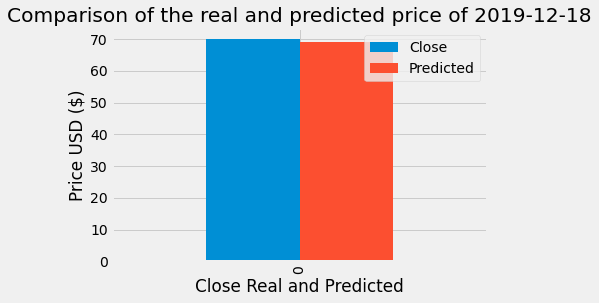

In [23]:
df = pd.DataFrame(data={'Close': [apple_quote2['Close'].values[0]],
                        'Predicted': [pred_price[0][0]]})
df.plot.bar();

plt.xlabel('Close Real and Predicted');
plt.ylabel('Price USD ($)');
plt.title('Comparison of the real and predicted price of 2019-12-18');